## Module Import

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import random
import numpy as np
import os

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

seed_torch()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

device : cuda


## Custom Dataset Class

In [2]:
class CustomMNISTDataset(Dataset):
    def __init__(self, data_path, train=True, transform=None):
        self.dataset = MNIST(root=data_path, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Hypher-Parameters

In [3]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10
validation_split = 0.2

# configs
data_path = './data'
log_path = './logs'
if not os.path.exists(log_path):
    os.mkdir(log_path)

## Data Split and Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = CustomMNISTDataset(data_path, train=True, transform=transform)
train_size = int((1 - validation_split) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

test_dataset = CustomMNISTDataset(data_path, train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Build MLP

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # MNIST는 10개 클래스
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, get_hidden = False):
        x = x.view(-1, 28 * 28)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        if get_hidden:
            return x
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

## Model, Loss, Optimizer

In [7]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Function

In [14]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

## Evaluation Function

In [16]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

## Train

In [17]:
BEST_ACC = 0.0
BEST_EPOCH = 0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    if val_accuracy > BEST_ACC:
        BEST_ACC = val_accuracy
        BEST_EPOCH = epoch+1
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.2f}%')

print(f'Best val accuracy : {BEST_ACC:.2f}% at Epoch {BEST_EPOCH}')

100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 95.59it/s]


Epoch [1/10], Train Loss: 0.1233, Train Accuracy: 96.24%, Valid Loss: 0.1130, Valid Accuracy: 96.57%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 99.88it/s]


Epoch [2/10], Train Loss: 0.0894, Train Accuracy: 97.26%, Valid Loss: 0.1001, Valid Accuracy: 97.03%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 95.87it/s]


Epoch [3/10], Train Loss: 0.0715, Train Accuracy: 97.79%, Valid Loss: 0.0947, Valid Accuracy: 97.26%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 95.34it/s]


Epoch [4/10], Train Loss: 0.0642, Train Accuracy: 98.02%, Valid Loss: 0.0999, Valid Accuracy: 97.15%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 99.98it/s]


Epoch [5/10], Train Loss: 0.0572, Train Accuracy: 98.19%, Valid Loss: 0.0870, Valid Accuracy: 97.47%


100%|█████████████████████████████████████████| 188/188 [00:02<00:00, 92.36it/s]


Epoch [6/10], Train Loss: 0.0506, Train Accuracy: 98.43%, Valid Loss: 0.0915, Valid Accuracy: 97.65%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 95.29it/s]


Epoch [7/10], Train Loss: 0.0479, Train Accuracy: 98.42%, Valid Loss: 0.0977, Valid Accuracy: 97.70%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 98.88it/s]


Epoch [8/10], Train Loss: 0.0423, Train Accuracy: 98.67%, Valid Loss: 0.0909, Valid Accuracy: 97.77%


100%|█████████████████████████████████████████| 188/188 [00:02<00:00, 92.03it/s]


Epoch [9/10], Train Loss: 0.0429, Train Accuracy: 98.68%, Valid Loss: 0.1084, Valid Accuracy: 97.29%


100%|█████████████████████████████████████████| 188/188 [00:01<00:00, 99.26it/s]

Epoch [10/10], Train Loss: 0.0374, Train Accuracy: 98.82%, Valid Loss: 0.0855, Valid Accuracy: 98.00%
Best val accuracy : 98.00% at Epoch 10


## Test

In [18]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 96.89it/s]

Test Loss: 0.0748, Test Accuracy: 98.19%


## t-SNE Visualization

In [19]:
def evaluate_and_collect_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # collecting embeddings for t-SNE visualization
            hidden = model(inputs, get_hidden=True)
            embeddings.append(hidden.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    embeddings = np.concatenate(embeddings)
    labels_list = np.concatenate(labels_list)
    return embeddings, labels_list

embeddings, labels = evaluate_and_collect_embeddings(model, test_loader, device)

In [20]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

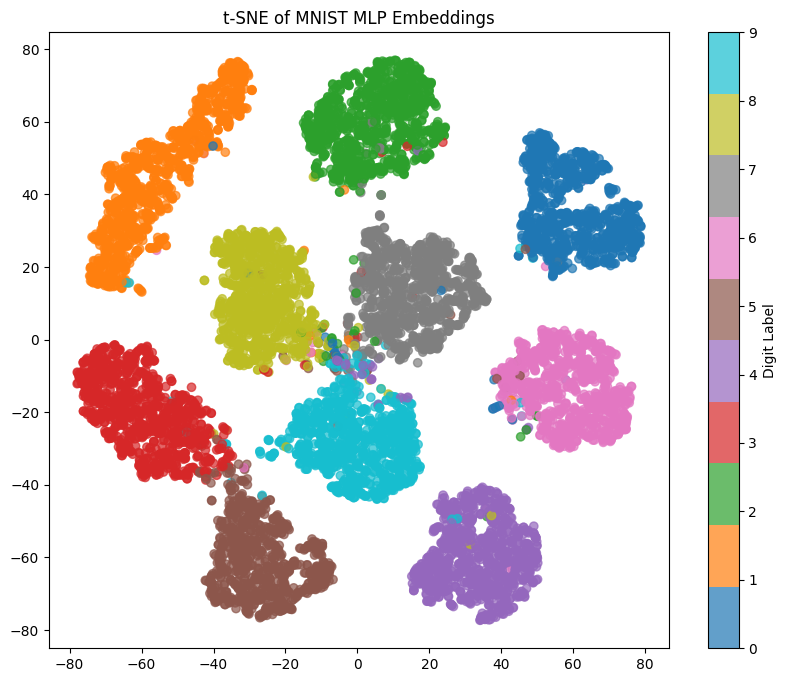

In [21]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title("t-SNE of MNIST MLP Embeddings")
plt.show()